In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from project.models.rnn_state_diffs import Processor
from project.datamodules.trajpred_dataset import TrajpredDataset
sns.set_theme()

In [2]:
# ------------
# Load Model
# ------------

# We also have to load the model processor, because we need to know how to process the data so we can also analyze the
# direct inputs to the model.
processor = Processor(
    rotate_scene=True,
    target_mode='position',
    # apg_max_range=19
)

In [3]:
# ------------
# Load dataset
# ------------

# Define which experiment you want to analyze
dataset = TrajpredDataset(
    data_dir='../../data',
    # datasets=['gym_corridor'],
    experiments=['nomap_univ'],
    save_tracks=True
)
dataset.process(processor)
fig_prefix = 'eth_univ'

100%|██████████| 1/1 [00:11<00:00, 11.72s/it]


Processing datasets:
-- ../../data/eth/test/nomap_univ.csv
Total dataset size: 408


## Analyzing the raw track data

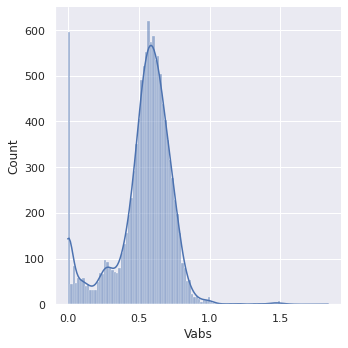

In [4]:
# ------------
# Velocity Profile
# ------------

# plt.figure()
dataset.tracks['Vabs'] = np.sqrt( dataset.tracks.Vx.values**2 + dataset.tracks.Vy.values**2)
p = sns.displot(data=dataset.tracks, x="Vabs", kde=True)
p.savefig(fig_prefix+'_vprofile.png')

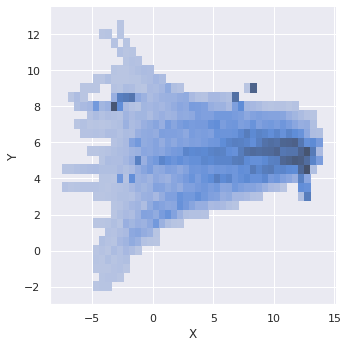

In [5]:
# ------------
# Map occupancy
# ------------
p = sns.displot(data=dataset.tracks, x="X", y="Y", binwidth=(.5, .5))
p.savefig(fig_prefix+'_occupancy.png')

# TODO: add background image
# with open(example['global_map_name']+'.yaml', 'r') as yaml_file:
#     map_state = yaml.safe_load(yaml_file)
#     map_state['image'] = cv2.flip(cv2.imread(example['global_map_name']+'.png'), 0)
#
# new_image = deepcopy(map_state['image'])


## Analyzing the model inputs

After filtering out tracks, depending on how short the tracks are (standing still) or if there are too much frame gaps
in the track.

Note: the model inputs depend on what kind of architecture is used. For now this notebook only supports the eth model.

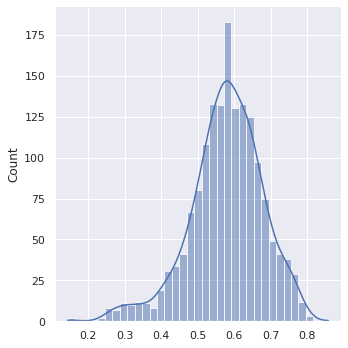

In [6]:
# ------------
# Ego input profile
# Note: This graph depends on whether the inputs are rotated w.r.t. the ego heading or not.
# ------------

V_abs = np.linalg.norm(dataset._data['ego_input'], axis=2).flatten()
p = sns.displot(x=V_abs, kde=True)
p.savefig(fig_prefix+'_vprofile_processed.png')

In [7]:
# ------------
# Angular pedestrian grid input profile
# Note: This graph depends on whether the inputs are rotated w.r.t. the ego heading or not.
# ------------

summed_apg = np.sum(dataset._data['apg_input'].reshape(-1, dataset._data['apg_input'].shape[-1]), axis=0)
summed_apg_norm = summed_apg/np.linalg.norm(summed_apg)
# d = {'Angles': angle, 'Radius': summed_apg_norm}
# df = pd.DataFrame(data=d)

### making the plot
# g = sns.FacetGrid(df, subplot_kws=dict(projection='polar'), height=5, sharex=False, sharey=False, despine=False)
# g.map_dataframe(sns.lineplot, x='Angles', y='Radius')

## making the plot
N = len(summed_apg_norm)
angle = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
bottom = 6
max_height = 8
width = (2*np.pi)/N
ax = plt.subplot(111, polar=True)
bars = ax.bar(angle, summed_apg_norm*max_height, width=width, bottom=bottom)

# Use custom colors and opacity
for r, bar in zip(summed_apg_norm*max_height, bars):
    bar.set_facecolor(plt.cm.jet(r / 5))
    bar.set_alpha(0.8)

plt.show()


KeyError: 'apg_input'

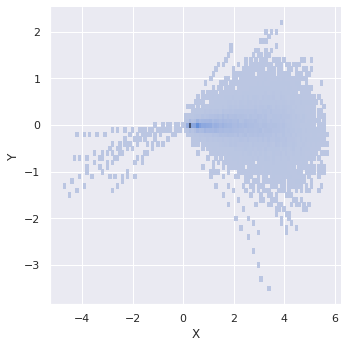

In [8]:
# ------------
# Average prediction target
# Note: This graph depends on whether the inputs are rotated w.r.t. the ego heading or not.
# Note: the target distribution is taken with the pedestrians current position as origin
# ------------

targets = dataset._data['target'].reshape(-1, 2)
df = pd.DataFrame(data=targets, columns=['X', 'Y'])

### making the plot
p = sns.displot(data=df, x="X", y="Y", binwidth=(.1, .1))
p.savefig(fig_prefix+'_pred_profile.png')

# g = sns.FacetGrid(df, subplot_kws=dict(projection='polar'), height=5, sharex=False, sharey=False, despine=False)
# g.map_dataframe(sns.scatterplot, x='Angles', y='Radius')
# plt.show()


In [9]:
# ------------
# Look at correlation between (apg / target) and (ego / target)
# Note: This graph depends on whether the inputs are rotated w.r.t. the ego heading or not.
# Note: the target distribution is taken with the pedestrians current position as origin
# ------------